In [125]:
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
cd ~/workspace/theislab/mubind/notebooks/batch

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/batch


In [127]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import numpy as np

In [128]:
df = mb.bindome.datasets.ProBound.ctcf(flank_length=0)
df = df.sort_values(1, ascending=False).reset_index(drop=True)
# data = df.head(1000)
# data = df.copy()

df.index = df['seq']
del df['seq']
df.index = df.index.astype(str).str[45:]

df = df[~df.index.duplicated(keep='first')]

n_sample = 15000
data = df.sample(min(df.shape[0], n_sample))

# data = mb.pp.sample_rounds(df, 2, 10000)

# remove as many nucleotides as posisble (faster training/convergence)


# data.index = data.index.astype(str).str[-15:]


In [129]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 1

In [130]:
# TODO: skipped for now
n_rounds = 2

print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds, labels=[0, 1])
train = tdata.DataLoader(dataset=dataset,
                         # batch_size=256,
                         batch_size=625,
                         shuffle=False)

loading object (# entries) 15000


In [131]:
import warnings
warnings.filterwarnings('ignore')

In [132]:
# %lprun -f mb.tl.train_network mb.tl.train_network(model, train, device, next_optimiser, criterion, num_epochs=20, early_stopping=100, log_each=2, dirichlet_regularization=0, exp_max=40, verbose=0)

In [133]:
# %lprun -f mb.tl.train_iterative mb.tl.train_iterative(train, device, w=18, show_logo=False, opt_kernel_shift=0, opt_kernel_length=0, dirichlet_regularization=dirichlet_regularization, lr=[0.01, 0.01], weight_decay=[0.01, 0.001], ignore_kernel=ignore_kernel, num_epochs=2, early_stopping=100, use_dinuc=False, n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None)

In [134]:
pd.set_option('display.expand_frame_repr', False)


In [135]:
model = mb.models.Multibind.make_model(train, 4, mb.tl.PoissonLoss()).cuda()

here... 2
Using device: cuda:0


In [136]:
model

Multibind(
  (padding): ConstantPad2d(padding=(19, 19, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (3): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
    )
    (conv_di): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(16, 19), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(16, 19), stride=(1, 1), bias=False)
      (3): Conv2d(1, 1, kernel_size=(16, 19), stride=(1, 1), bias=False)
    )
  )
  (activities): ActivitiesLayer(
    (log_activities): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 1x2 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 1x2 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 1x2 (GPU 0)]
        (3): Parameter containing: [to

In [137]:
# assign batch and data type

# data['batch'] = 0
# data['is_count_data'] = 1
# n_batches=3

dirichlet_regularization = 0
# for dirichlet_regularization_log in range(-5, 3):

n_epochs = 200
log_each = 10
n_kernels = 4
w = 20 # min(len(motif), 6)
lr = [0.01] * n_kernels
wd = [0.01,] + [0.001] * (n_kernels - 1)
early_stopping = [5,] + [25] * (n_kernels - 1)
opt_kernel_shift=[0, 0, 1, 1]
opt_kernel_length=[0, 0, 1, 1]
use_mono = True
use_dinuc = False
dinuc_mode = 'local'

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 1

import time
t0 = time.time()

criterion = mb.tl.PoissonLoss()

for ignore_kernel in [1]: # [0, 1]:
    print('\n\n##NEW JOB')
    print('ignore kernel', ignore_kernel)
    print('# trials', data.shape[0])

    model = mb.models.Multibind.make_model(train, 4, mb.tl.PoissonLoss(), kernels=[0, 2, 20, 20]).cuda()

    print(model)
    model_by_k, results = model.optimize_iterative(train, show_logo=0,
                                                    dirichlet_regularization=dirichlet_regularization, # 10 ** dirichlet_regularization_log,
                                                    # lr=lr, weight_decay=wd, ignore_kernel=ignore_kernel,
                                                    use_mono=use_mono,
                                                    use_dinuc=use_dinuc,
                                                    dinuc_mode=dinuc_mode,
                                                    opt_kernel_shift=opt_kernel_shift,
                                                    opt_kernel_length=opt_kernel_length,
                                                    num_epochs=n_epochs, early_stopping=early_stopping, # optimiser=torch.optim.LBFGS,
                                                    log_each=log_each, stop_at_kernel=None) #  seed=seed) # seeds.index[0]) #
    print('##DONE....\n\n')



print('total time: %.3f s' % ((time.time() - t0)))
# res = []
# model_by_k = {}

model = model_by_k





##NEW JOB
ignore kernel 1
# trials 15000
here... 2
Using device: cuda:0
Multibind(
  (padding): ConstantPad2d(padding=(19, 19, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (3): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
    )
    (conv_di): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(16, 1), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(16, 19), stride=(1, 1), bias=False)
      (3): Conv2d(1, 1, kernel_size=(16, 19), stride=(1, 1), bias=False)
    )
  )
  (activities): ActivitiesLayer(
    (log_activities): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 1x2 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 1x2 (GPU 0)]
        (2): Parameter containing: [torch.cuda

In [138]:
model = model_by_k
mb.tl.scores(model, train, by='batch')


{0: {'r2_counts': 0.08111262225889249,
  'r2_foldchange': 0.03951169577354785,
  'r2_enr': -0.031480717782787604,
  'r2_fc': 0.04192418938010903,
  'pearson_foldchange': 0.2047539728066565}}

In [139]:
rcParams['figure.figsize'] = 6, 6


In [140]:
counts = mb.tl.predict(model, train)
counts

,t0,t1,p0,p1,batch,n_rounds,enr_pred,enr_obs,f_pred,f_obs
TCGGTCAGCCTGAGATTGGGAATAG,1.0,0.0,0.612503,0.387497,0,2,0.860462,0.5,-0.065269,-0.30103
ACGTTGTCTATAATCCGTCATAGGG,1.0,0.0,0.591475,0.408525,0,2,0.885044,0.5,-0.053035,-0.30103
GCTGCGTAATTTCGGGGGACAGTCA,0.0,1.0,0.603585,0.396415,0,2,0.870808,2.0,-0.060078,0.30103
TGGTAATGGTCTGCAGCCACCTGGT,0.0,1.0,0.426107,0.573893,0,2,1.103629,2.0,0.042823,0.30103
CATGTAGGGGCCTCTCGAGTCAATC,0.0,1.0,0.375301,0.624699,0,2,1.181340,2.0,0.072375,0.30103
...,...,...,...,...,...,...,...,...,...,...
GCGGATGATAGTGAAGATAAATATA,1.0,0.0,0.628655,0.371345,0,2,0.842011,0.5,-0.074682,-0.30103
CAAGCAAAAAGGGTTGATCACCGTT,0.0,1.0,0.620526,0.379474,0,2,0.851250,2.0,-0.069943,0.30103
GTGGTTGCAACGCATGCAGCTGGGT,1.0,0.0,0.568114,0.431886,0,2,0.913127,0.5,-0.039469,-0.30103
AGCACTGATGCTGGCGGCGGGGAGA,0.0,1.0,0.533673,0.466327,0,2,0.956089,2.0,-0.019502,0.30103


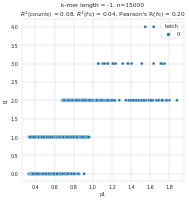

{'r2_counts': 0.08111262225889249,
 'r2_foldchange': 0.03951169577354785,
 'r2_enr': -0.031480717782787604,
 'r2_fc': 0.04192418938010903,
 'pearson_foldchange': 0.2047539728066565}

In [141]:
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 35

mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')


True
4
(4, 4)
(76, 76)
(76, 76)


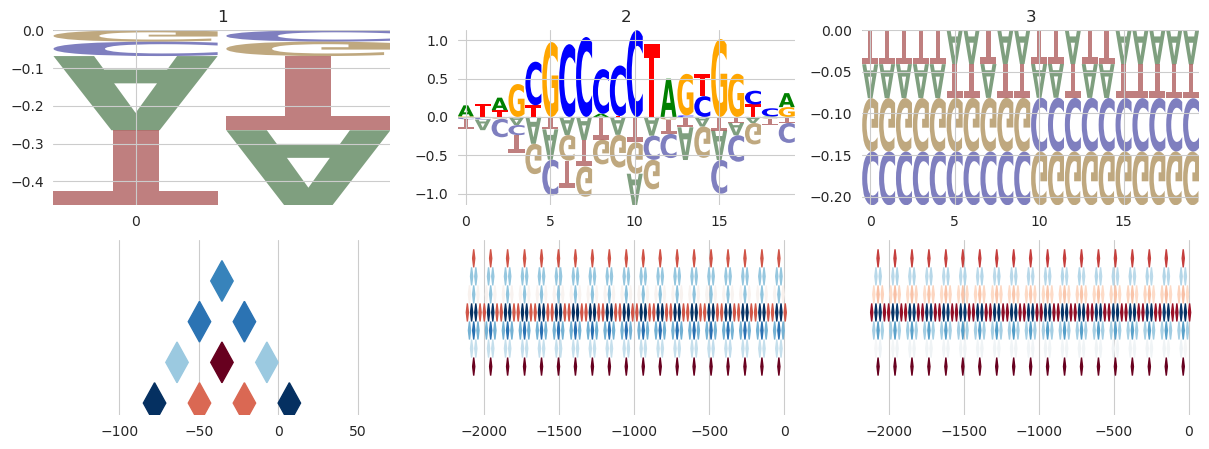

In [142]:
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=2)


In [143]:

model = model_by_k
mb.tl.scores(model, train, k=9)


{'r2_counts': 0.5237956630593181,
 'r2_foldchange': 0.04639164662936601,
 'r2_enr': 0.010371877639845484,
 'r2_fc': 0.05292414066994018,
 'pearson_foldchange': 0.23005247373140802}

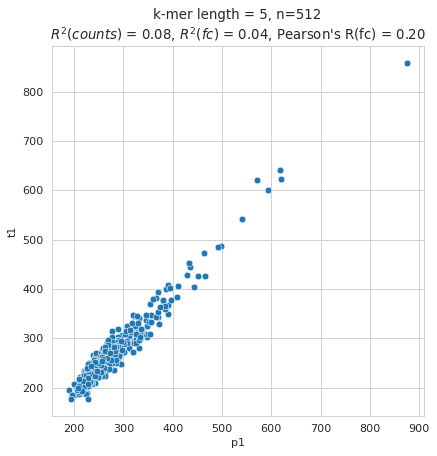

{'r2_counts': 0.08111262225889249,
 'r2_foldchange': 0.03951169577354785,
 'r2_enr': -0.031480717782787604,
 'r2_fc': 0.04192418938010903,
 'pearson_foldchange': 0.2047539728066565}

In [144]:
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 80

mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=5)
